<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/ML_in_business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting a Location for an Oil Well

## Project Overview

GlavRosGosNeft is planning to drill a new well and needs to select the most profitable region for extraction. The goal is to build a machine learning model that predicts the volume of oil reserves in new wells and evaluate potential profits and risks using the Bootstrap technique.

**Project Goal**

Identify the region with the highest average profit while ensuring the probability of loss is less than 2.5%.

**Key Constraints & Conditions**
- **Model**: Only `Linear Regression` is used (for maximum predictability).
- **Selection**: During exploration, 500 points are researched; the top 200 are selected for development based on model predictions.
- **Budget**: `10 billion rubles` for regional development.
- **Revenue**: `450,000 rubles` per unit of product (1,000 barrels).
- **Risk Threshold**: Only regions with a probability of loss `< 2.5%` will be considered.

**Project Workflow**:
1. [**Data Loading and Preparation**](#Loading)
- Import data from the provided files.
- Examine the data structure (well ID, features f0, f1, f2, and reserve volume product).
- Check for missing values and duplicates.

2. [**Model Training and Validation for Each Region**](#Training)
- Split the data into training and validation sets (75:25 ratio).
- Train a Linear Regression model and generate predictions for the validation set.
- Save the predictions and actual reserve volumes.
- Calculate the average predicted volume and the model's RMSE.
- Analyze the results for each region.

3. [**Profit Calculation Preparation**](#Profit)
- Define key constants for calculations: budget, revenue per unit of product, and the number of top wells to select.
- Calculate the break-even volume of reserves required for development. Compare this volume with the predicted average reserves.
- Draw conclusions regarding the feasibility of break-even development in each region.

4. [**Profit Calculation Function**](#Function)
- Select the top 200 wells based on the highest predicted values.
- Aggregate the actual reserve volume for these selected wells.
- Calculate the profit based on the predicted reserve volumes.

5. [**Risk and Profit Analysis**](#Risk)
- Apply the Bootstrap technique (1000 samples) to estimate the profit distribution.

- Calculate:
   - Average Profit;
   - 95% Confidence Interval;
   - Probability of Loss.

6. [Final Conclusion](#Conclusion)
- Select the region with the highest average profit and a risk of loss below 2.5%.

## Data Description

Geological exploration data for three regions are stored in the following files:

- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

**Features:**
- `id`: unique well identifier;
- `f0`, `f1`, `f2`: three point features (the specific meaning is undisclosed, but the features are significant);
- `product`: volume of reserves in the well (thousand barrels).

## <a name='Loading'></a> Data Loading and Preparation

### Libraries import

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Functions

In [4]:
# Function to get comprehensive information about dataframes
def detailed_df_analysis(df):
    display(df.head())
    print('')
    display(df.info())
    print('')
    display(df.describe().T)
    print('')

    # Missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print("Missing values:")
    print(pd.DataFrame({'count': missing_values, 'percentage': missing_percent}), "\n")

    # Number of duplicate rows
    duplicates = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}\n")

    # Checking for non-unique IDs
    id_duplicates = df['id'].value_counts()
    # print('Number of implicit duplicates in "id" column:', len(df) - id_duplicates.count())
    # print('')

    # Categorical column information
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("Categorical features information:")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            print(f"{col} => {unique_count} unique values")
        print()

    # Distribution of the numerical target variable 'product'
    if 'product' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['product'], kde=True, bins=30, color='blue')
        plt.title("Distribution of 'product'")
        plt.xlabel('Reserve volume (thousand barrels)')
        plt.ylabel('Frequency')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['product'], color='cyan')
        plt.title("Boxplot of 'product'")
        plt.xlabel('Reserve volume (thousand barrels)')

        plt.tight_layout()
        plt.show()

In [5]:
# Function to plot a histogram for a specified column
# Accepts the series, number of bins, and axis limits
def hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0, xlim_max])
    plt.ylim([0, ylim_max])

    plt.xlabel("Oil volume per well, thousand barrels")
    plt.ylabel("Number of wells")

    plt.title("Histogram of well volume distribution")
    plt.show()

In [16]:
def ml_regression(features, target, region):

    # Split data into training and validation sets
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        random_state=12345,
        test_size=0.25
    )

    # Standardization of numerical features
    scaler = StandardScaler()
    numeric = ['f0', 'f1', 'f2']

    # Use .copy() to prevent SettingWithCopyWarning
    features_train = features_train.copy()
    features_valid = features_valid.copy()

    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    # Model initialization and training
    model = LinearRegression()
    model.fit(features_train, target_train)

    # Prediction
    predicted = model.predict(features_valid)

    # Calculate RMSE using the updated method
    rmse = root_mean_squared_error(target_valid, predicted)

    print(f'Average predicted reserve volume in {region}: {predicted.mean():.4f}')
    print(f'Model RMSE: {rmse:.4f}')
    print('------')

    # Storing results for further analysis
    results_df = pd.DataFrame({
        'actual': target_valid,
        'predicted': predicted
    })

    return pd.Series(predicted, index=target_valid.index), target_valid, results_df

### Data Loading

In [3]:
# Reading data
first_geo = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/geo_data_0.csv')
second_geo = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/geo_data_1.csv')
third_geo = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/geo_data_2.csv')

### Data Exploration

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Missing values:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Number of duplicates: 0

Categorical features information:
id => 99990 unique values



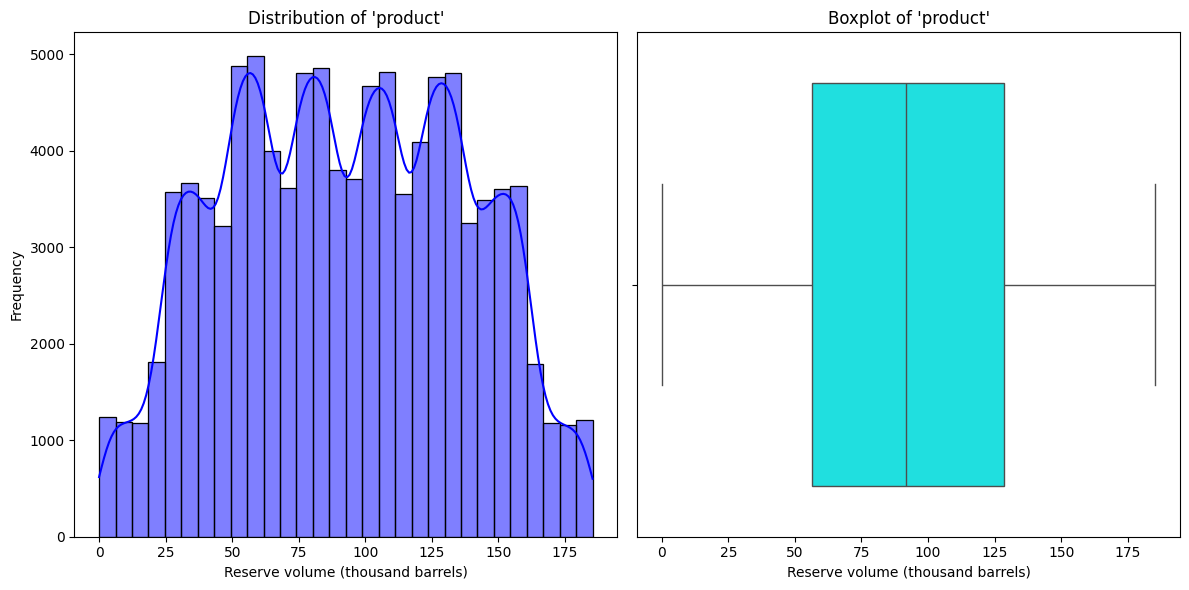

In [6]:
detailed_df_analysis(first_geo)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Missing values:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Number of duplicates: 0

Categorical features information:
id => 99996 unique values



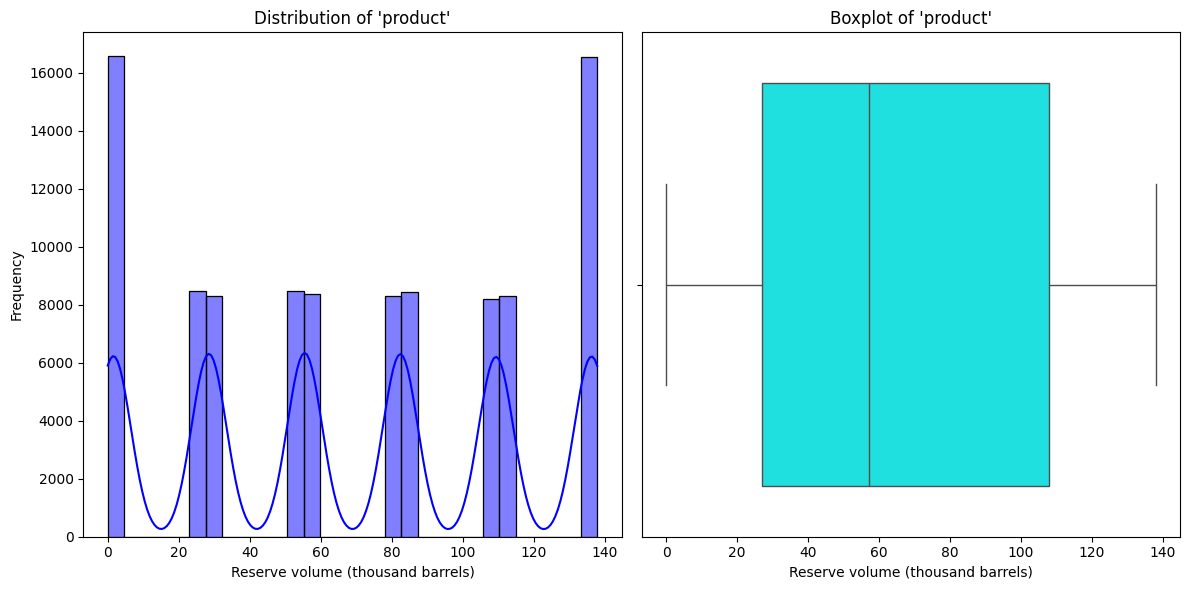

In [7]:
detailed_df_analysis(second_geo)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Missing values:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Number of duplicates: 0

Categorical features information:
id => 99996 unique values



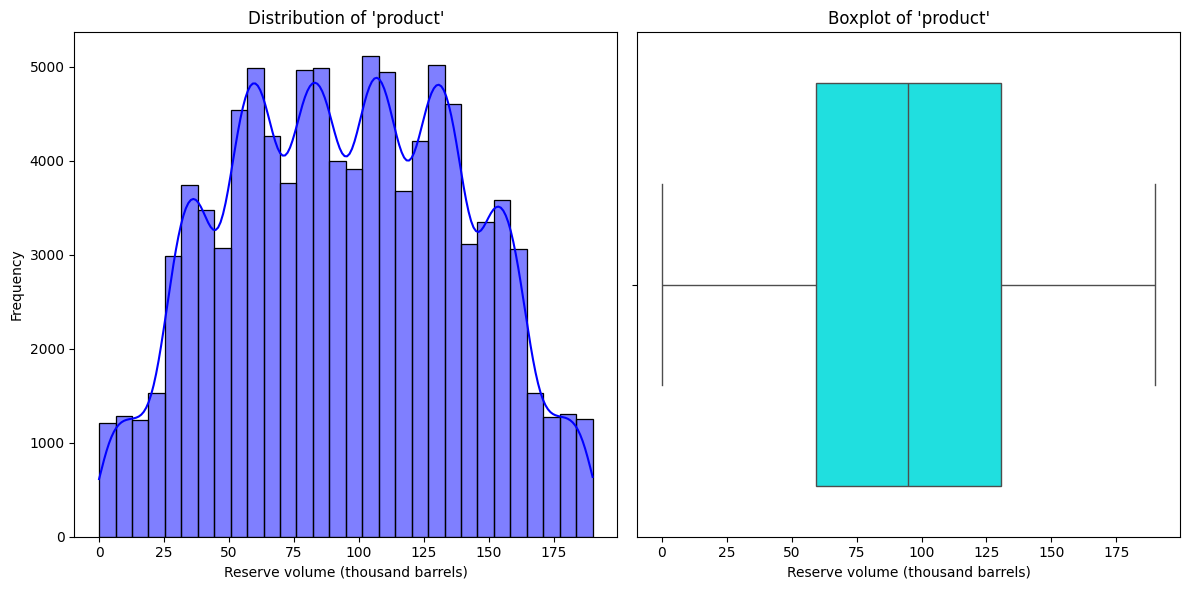

In [8]:
detailed_df_analysis(third_geo)

- No missing values detected.
- No explicit duplicates found.
- Data types are correct.
- The distribution of the target variable product in the second region looks very unusual.
- No outliers detected.

Based on the plots and initial exploratory data analysis, the `product` column contains non-null values that are likely zeros. This needs to be verified by calculating the exact number of zero values.

In [9]:
# Checking the distribution of 'product' in the second dataset
# Function to count zero values in a specified column
def zeros_count(df, column):
    zeros = df[df[column] == 0][column].count()
    percent = zeros / df.shape[0]
    print('Number of zero values:', zeros)
    print(f'Percentage of zero values: {percent:.2%}')

In [10]:
zeros_count(first_geo, 'product')

Number of zero values: 1
Percentage of zero values: 0.00%


In [11]:
zeros_count(second_geo, 'product')

Number of zero values: 8235
Percentage of zero values: 8.24%


In [12]:
zeros_count(third_geo, 'product')

Number of zero values: 1
Percentage of zero values: 0.00%


The distribution in the second table looks synthetic; it was likely generated or modified intentionally.

### Data Preprocessing

In [13]:
# Set index to 'id'
first_geo = first_geo.set_index('id')
second_geo = second_geo.set_index('id')
third_geo = third_geo.set_index('id')

# Drop target feature from features
features_first_geo = first_geo.drop('product', axis=1)
features_second_geo = second_geo.drop('product', axis=1)
features_third_geo = third_geo.drop('product', axis=1)

# Extract target features
target_first_geo = first_geo['product']
target_second_geo = second_geo['product']
target_third_geo = third_geo['product']

The data is in order and ready for further processing.

## <a name='Training'></a> Model Training and Validation for Each Region

### Linear Regression Training

- Since we have three similar datasets, it is efficient to create a single function for model training.
- According to the project requirements, only the `Linear Regression` model should be used, as other methods may be less predictable in this context.
- It is also important to apply `standardization` to the numerical features for each split sample.
- We will use `RMSE` as the primary metric, as it effectively reflects the actual deviation of predictions from real values.

In [18]:
# Train models and save results
predicted_first_geo, correct_first_geo, df_first_geo = ml_regression(features_first_geo, target_first_geo, 'first_region')
predicted_second_geo, correct_second_geo, df_second_geo = ml_regression(features_second_geo, target_second_geo, 'second_region')
predicted_third_geo, correct_third_geo, df_third_geo = ml_regression(features_third_geo, target_third_geo, 'third_region')

# Align the indexing of predicted values with actual values
predicted_first_geo.index = correct_first_geo.index
predicted_second_geo.index = correct_second_geo.index
predicted_third_geo.index = correct_third_geo.index

Average predicted reserve volume in first_region: 92.5926
Model RMSE: 37.5794
------
Average predicted reserve volume in second_region: 68.7285
Model RMSE: 0.8931
------
Average predicted reserve volume in third_region: 94.9650
Model RMSE: 40.0297
------


In [19]:
display(predicted_first_geo.shape)
display(correct_first_geo.shape)
display(df_first_geo.head())

(25000,)

(25000,)

,actual,predicted
id,,
7Z2gx,10.038645,95.894952
b2HU8,114.551489,77.572583
Y0dXD,132.603635,77.892640
Mje59,169.072125,90.175134
yqXxU,122.325180,70.510088


In [20]:
# To estimate total region reserves, we aggregate values from the calculated datasets
print('Total predicted reserves in Region 0:', predicted_first_geo.sum())
print('Total actual reserves in Region 0:', correct_first_geo.sum())
print()
print('Total predicted reserves in Region 1:', predicted_second_geo.sum())
print('Total actual reserves in Region 1:', correct_second_geo.sum())
print()
print('Total predicted reserves in Region 2:', predicted_third_geo.sum())
print('Total actual reserves in Region 2:', correct_third_geo.sum())

Total predicted reserves in Region 0: 2314814.194609509
Total actual reserves in Region 0: 2301964.918520732

Total predicted reserves in Region 1: 1718213.67238615
Total actual reserves in Region 1: 1718078.4006089992

Total predicted reserves in Region 2: 2374126.1492001223
Total actual reserves in Region 2: 2372105.8202213594


**Model Training Conclusions:**
- The total predicted volumes align closely with the total actual measurement results across all regions.
- The model performed exceptionally well in predicting reserves for the second region, achieving an `RMSE of 0.8931`. It is highly likely that the structured (potentially synthetic) nature of the data in the second dataset led to high model precision or slight overfitting. However, due to the specific data structure and the lower average reserve volume (`68.73`), this region may not necessarily be the most profitable despite the prediction accuracy.
- The highest average reserve volume per well was observed in the third region, with a value of `94.965` thousand barrels.

## <a name='Profit'></a> Profit Calculation Preparation`

In [21]:
# Constants for key values
# Budget: 10 billion rubles
BUDGET = 10 ** 10
# Number of points to research during exploration
EXPLORATION_POINTS = 500
# Number of top points to select based on the model
TOP_POINTS = 200
# Revenue per unit (1,000 barrels). Price per barrel is 450 rubles.
REVENUE_PER_UNIT = 450000

In [22]:
# Break-even calculations
required_revenue_per_well = BUDGET / TOP_POINTS
print(f'Required average revenue per top well: {required_revenue_per_well / 1000:.2f} thousand rubles')

required_volume_per_well = required_revenue_per_well / REVENUE_PER_UNIT
print(f'Required average oil volume per well (break-even): {required_volume_per_well:.2f} thousand barrels')

total_required_volume = BUDGET / REVENUE_PER_UNIT
print(f'Total required oil volume per region: {total_required_volume:.2f} thousand barrels')

Required average revenue per top well: 50000.00 thousand rubles
Required average oil volume per well (break-even): 111.11 thousand barrels
Total required oil volume per region: 22222.22 thousand barrels


Currently, the highest predicted average reserve volume (found in the third region) is `94.97` thousand barrels, which is below the calculated break-even point of `111.11` thousand barrels. Similarly, the average reserves in the first and second regions do not reach the required break-even level. However, we should examine the distributions.

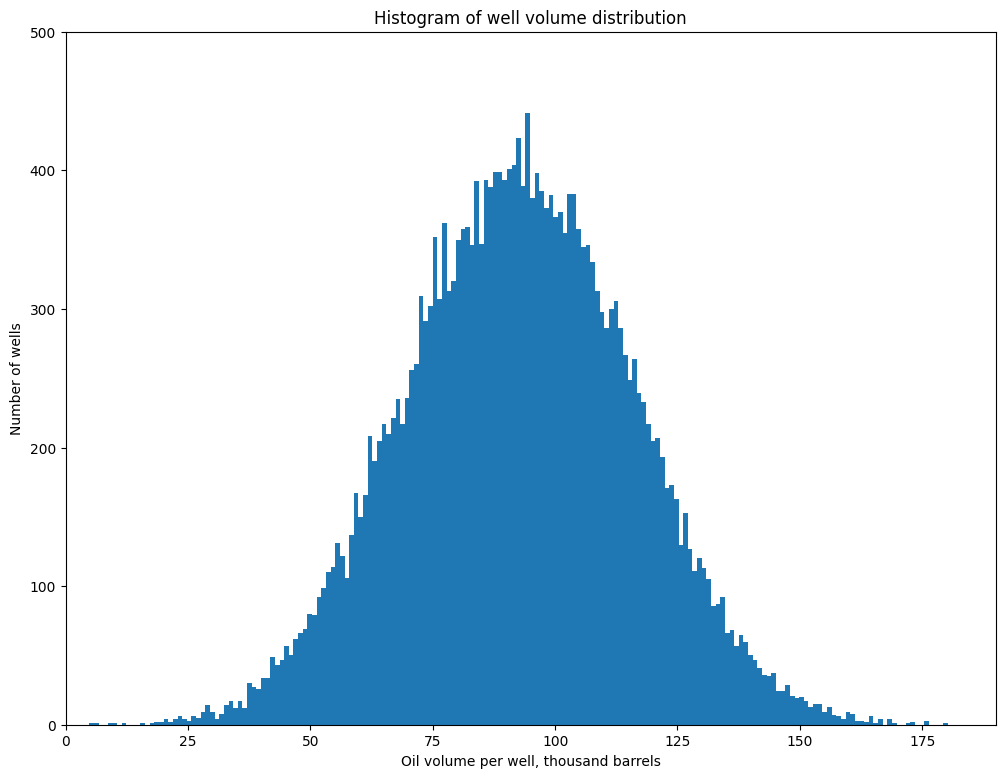

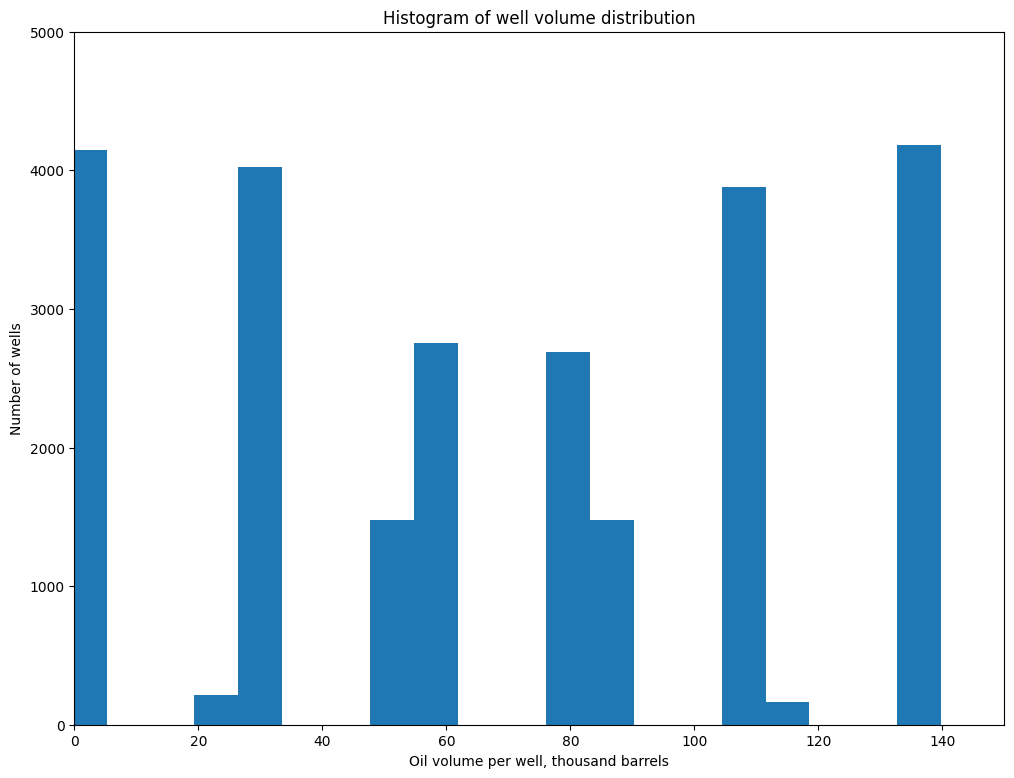

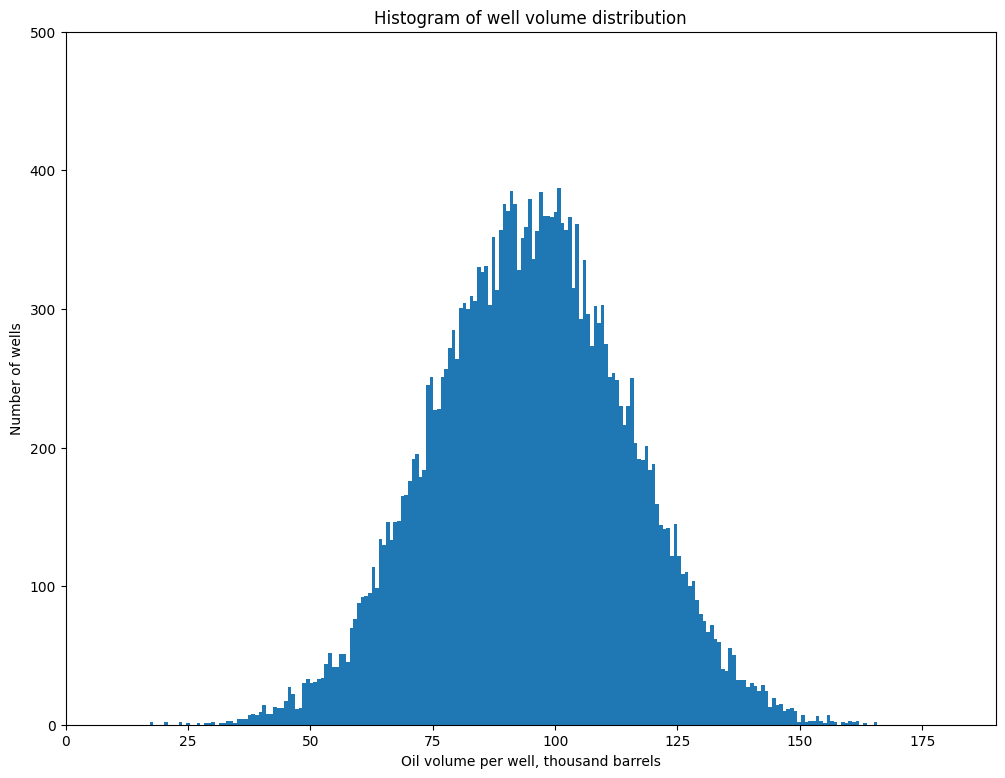

In [23]:
# Check the distribution of predicted reserve volumes per well
# Evaluate the histograms relative to the break-even volume calculated above
hist(df_first_geo['predicted'], 200, 190, 500)
hist(df_second_geo['predicted'], 20, 150, 5000)
hist(df_third_geo['predicted'], 200, 190, 500)

- For the first and third regions, there is a high probability of recovering the investment.
- The variance around the mean values (92.6 and 95.0, respectively) indicates that there is a significant number of wells with reserves exceeding the required break-even threshold of 111.11 thousand barrels.

## <a name='Function'></a> Profit Calculation Function

In [24]:
# Function to calculate profit for the top wells among 500 explored points
def revenue_count(target, probabilities_sample, count):
    # Sort points by predicted probabilities/volumes in descending order
    probs_sorted = probabilities_sample.sort_values(ascending=False)
    # Select the target values for the top wells based on predictions
    selected = target[probs_sorted.index][:count]
    # Calculate profit: (revenue per unit * total volume) - development budget
    return REVENUE_PER_UNIT * selected.sum() - BUDGET

In [25]:
state = np.random.RandomState(12345)

# Function to apply the Bootstrap technique with 1000 samples
def bootstrap(target, probabilities):
    values = []
    lost_counts = 0

    for i in range(1000):
        # Create a sample of 500 points with replacement
        target_sample = target.sample(replace=True, random_state=state, n=EXPLORATION_POINTS)
        probs_sample = probabilities[target_sample.index]

        # Calculate profit for the best 200 wells in this sample
        profit = revenue_count(target, probs_sample, TOP_POINTS)

        if profit < 0:
            lost_counts += 1
        values.append(profit)

    values = pd.Series(values)
    lower = values.quantile(0.025) # 2.5th percentile
    upper = values.quantile(0.975) # 97.5th percentile
    average = values.mean()
    risk = lost_counts / 1000

    return average, lower, upper, risk

## <a name='Risk'></a> Risk and Profit Analysis

In [26]:
# Analysis for Region 1
average_1, lower_1, upper_1, risk_1 = bootstrap(df_first_geo['actual'], df_first_geo['predicted'])
print('--- Data for Region 1 ---')
print(f'Average profit: {average_1 / 1000:,.2f} thousand rubles')
print(f'95% Confidence Interval: from {lower_1 / 1000:,.2f} to {upper_1 / 1000:,.2f} thousand rubles')
print(f'Risk of loss: {risk_1:.2%}')
print()

--- Data for Region 1 ---
Average profit: 396,164.98 thousand rubles
95% Confidence Interval: from -111,215.55 to 909,766.94 thousand rubles
Risk of loss: 6.90%



In [27]:
# Analysis for Region 2
average_2, lower_2, upper_2, risk_2 = bootstrap(df_second_geo['actual'], df_second_geo['predicted'])
print('--- Data for Region 2 ---')
print(f'Average profit: {average_2 / 1000:,.2f} thousand rubles')
print(f'95% Confidence Interval: from {lower_2 / 1000:,.2f} to {upper_2 / 1000:,.2f} thousand rubles')
print(f'Risk of loss: {risk_2:.2%}')
print()

--- Data for Region 2 ---
Average profit: 461,155.82 thousand rubles
95% Confidence Interval: from 78,050.81 to 862,952.06 thousand rubles
Risk of loss: 0.70%



In [28]:
# Analysis for Region 3
average_3, lower_3, upper_3, risk_3 = bootstrap(df_third_geo['actual'], df_third_geo['predicted'])
print('--- Data for Region 3 ---')
print(f'Average profit: {average_3 / 1000:,.2f} thousand rubles')
print(f'95% Confidence Interval: from {lower_3 / 1000:,.2f} to {upper_3 / 1000:,.2f} thousand rubles')
print(f'Risk of loss: {risk_3:.2%}')

--- Data for Region 3 ---
Average profit: 392,950.48 thousand rubles
95% Confidence Interval: from -112,227.63 to 934,562.91 thousand rubles
Risk of loss: 6.50%


We exclude the first and third regions because their risks are relatively high (6.9% and 6.5%, respectively), exceeding the 2.5% threshold.

This leaves us with Region 2. Its risk of loss is significantly lower than the requirement (0.7%). Furthermore, the 95% confidence interval demonstrates that development will remain profitable even under less-than-ideal well selection scenarios.

## <a name='Conclusion'></a> Final Conclusion

**Data Loading and Preparation:**
- Imported necessary libraries and loaded three datasets: first_geo, second_geo, and third_geo.
- Developed the detailed_df_analysis function to obtain general information about the data.
- Determined that the data is in order and ready for further processing:
   - No missing values or explicit duplicates were found.
   - Data types are correct.
   - No anomalous values were detected.

**Data Preparation for Model Training:**

- Indexed the samples by id.
- Separated features and target variables in the data.

**Model Training and Validation**:
- Developed a function to train a LinearRegression model, which:
   - Splits the loaded dataset into training and validation sets in a 75:25 ratio;
   - Applies standardization to all samples based on numerical features;
   - Trains the linear regression model;
   - Records the model's predictions;
   - Displays the average reserve volume in a specific region and the Root Mean Squared Error (RMSE) of the model.
- The model showed its best predictive performance in the second region: RMSE - `0.8931`.
- The highest average reserve volume was observed in the third region: `94.9650`.

**Preparation for Profit Calculation:**

- Defined key constants to fulfill the research conditions.
- Calculated key indicators to evaluate the region's profitability:
- Required average profit per well: `50,000.0 thousand rubles`.
- Required average oil volume per well for break-even: `111.11 thousand barrels`.
- Required average oil volume per region: `22,222.22 thousand barrels`.

**Profit and Risk Calculation:**

Created the revenue_count function to calculate profit.
- Applied the Bootstrap method: generated 1,000 samples of 500 wells each and calculated the necessary metrics.
- Calculated profit and risks for each region, providing justification for selecting the most suitable region. The second region showed one of the best predictive results; however, the data distribution differs from a normal distribution, which raises questions regarding the accuracy of the results:
   - **Average profit for the region**: 461,155.82 thousand rubles.
   - **95% confidence interval**: from 78,050,810.75 to 862,952,060.26 thousand rubles.
   - **Risk of loss**: 0.7%.